In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [170]:
velha = pd.read_csv('amostras_.csv',sep=';')

In [171]:
X = velha.drop(columns=['classe'])
y = velha['classe'].values


In [172]:
treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=42,test_size=0.1, stratify=y)
tr_X, v_X, tr_y, v_y = tts(treino_X, treino_y, random_state=42,test_size=0.11, stratify=treino_y)
print(v_X.shape)
print(teste_X.shape)


(75, 9)
(75, 9)


Validacao Cruzada com GridSearchCV

In [173]:
param_grid = {'n_neighbors': range(2, 20)}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=10,         # 10-fold cross-validation
    scoring='accuracy'
)
grid.fit(tr_X, tr_y)
print("Melhor k:", grid.best_params_)

Melhor k: {'n_neighbors': 12}


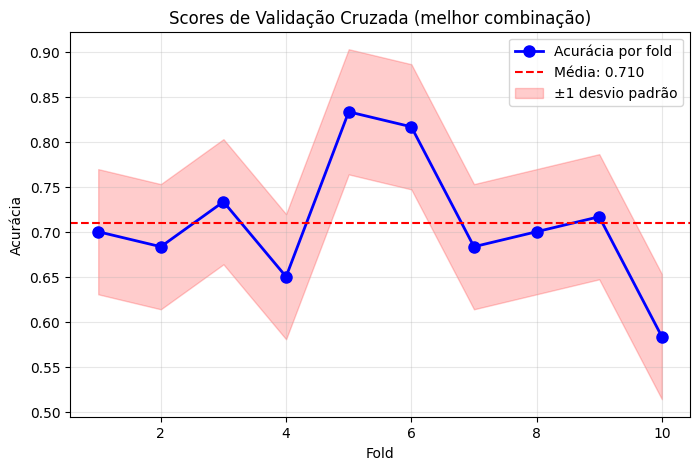

In [174]:
df = pd.DataFrame(grid.cv_results_)

# índice da melhor combinação de hiperparâmetros
best_idx = grid.best_index_

# pega os scores de cada fold para essa combinação
fold_cols = [c for c in df.columns if c.startswith("split") and c.endswith("_test_score")]
fold_scores = df.loc[best_idx, fold_cols].values.astype(float)

# calcula média e desvio padrão
mean_score = fold_scores.mean()
std_score = fold_scores.std()

# plota
plt.figure(figsize=(8,5))
plt.plot(range(1, len(fold_scores)+1), fold_scores, "bo-", linewidth=2, markersize=8, label="Acurácia por fold")

# linha da média
plt.axhline(y=mean_score, color="r", linestyle="--", label=f"Média: {mean_score:.3f}")

# faixa do desvio padrão em torno da média
plt.fill_between(range(1, len(fold_scores)+1),
                 fold_scores - std_score,
                 fold_scores + std_score,
                 alpha=0.2, color="red", label="±1 desvio padrão")

plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.title("Scores de Validação Cruzada (melhor combinação)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Matriz de confusao (Cruzada)

In [175]:
clf = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
clf.fit(tr_X, tr_y)
y_pred_cru = clf.predict(v_X)  # usa DataFrame com nomes de features
cm = confusion_matrix(v_y, y_pred_cru)

Validacao Explicita (10%)

In [176]:
melhor_k = None
melhor_acc = 0 
k_values = []
accuracies=[]
for k in range(2, 20):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(tr_X, tr_y)
    acc = clf.score(v_X,v_y)
    k_values.append(k)
    accuracies.append(acc)

    if acc > melhor_acc:
        melhor_acc = acc
        melhor_k = k

acc_expl = melhor_acc
print(f'Melhor acuracia: {melhor_acc}')
print("Melhor k encontrado:", melhor_k)

Melhor acuracia: 0.7333333333333333
Melhor k encontrado: 15


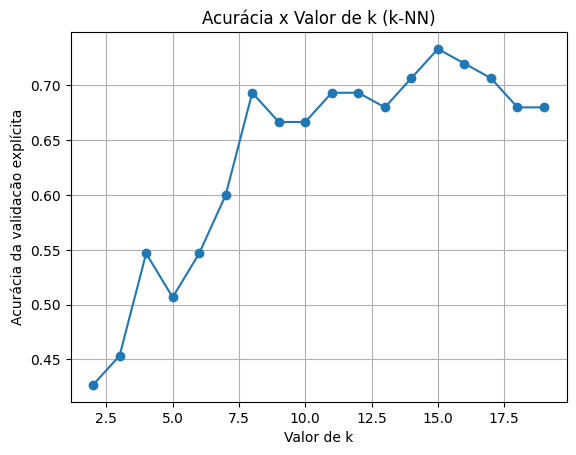

In [177]:
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("Valor de k")
plt.ylabel("Acurácia da validacão explícita")
plt.title("Acurácia x Valor de k (k-NN)")
plt.grid(True)
plt.show()

Matriz de Confusao da validacao explicita

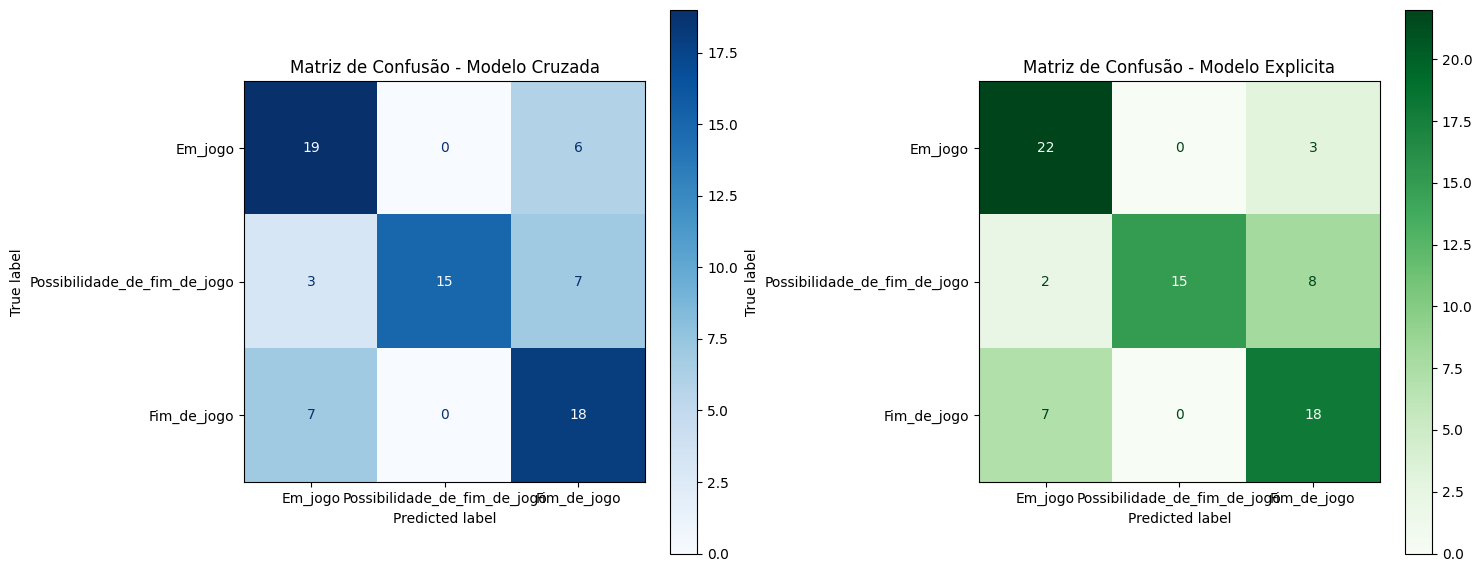

Relatório de Classificação - Modelo Cruzado:
Acurácia  0.6933333333333334
                              precision    recall  f1-score   support

                     Em_jogo       0.66      0.76      0.70        25
Possibilidade_de_fim_de_jogo       1.00      0.60      0.75        25
                 Fim_de_jogo       0.58      0.72      0.64        25

                    accuracy                           0.69        75
                   macro avg       0.75      0.69      0.70        75
                weighted avg       0.75      0.69      0.70        75

Relatório de Classificação - Modelo Explicito:
Acurácia  0.7333333333333333
                              precision    recall  f1-score   support

                     Em_jogo       0.71      0.88      0.79        25
Possibilidade_de_fim_de_jogo       1.00      0.60      0.75        25
                 Fim_de_jogo       0.62      0.72      0.67        25

                    accuracy                           0.73        75
     

In [178]:
clf = KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X, tr_y)
y_pred_expl = clf.predict(v_X)  # usa DataFrame com nomes de features

# Matriz de confusão do modelo otimizado
cm_expl = confusion_matrix(v_y, y_pred_expl)

# Comparação das matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz original
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusão - Modelo Cruzada')

# Matriz otimizada
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_expl, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Matriz de Confusão - Modelo Explicita')

plt.tight_layout()
plt.show()

# Relatório de classificação do modelo otimizado
print("Relatório de Classificação - Modelo Cruzado:")
print('Acurácia ',accuracy_score(v_y, y_pred_cru))
print(classification_report(v_y, y_pred_cru, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))
# Relatório de classificação do modelo otimizado

print("Relatório de Classificação - Modelo Explicito:")
print('Acurácia ',accuracy_score(v_y, y_pred_expl))
print(classification_report(v_y, y_pred_expl, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))


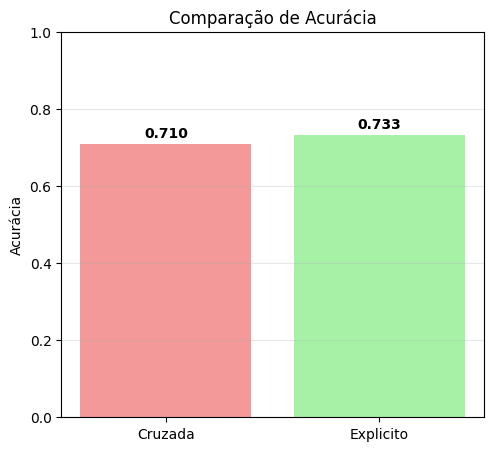

In [179]:
# Visualização da comparação de performance
plt.figure(figsize=(12, 5))

# Gráfico 1: Comparação de acurácias
plt.subplot(1, 2, 1)
models = ['Cruzada', 'Explicito']
accuracies = [grid.best_score_, acc_expl]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.ylim(0, 1)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

SCORE DO TESTE COM K VIA VALIDACAO EXPLICITA

In [180]:
clf = neighbors.KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X, tr_y)
accs = clf.score(teste_X, teste_y)
print("Acuracia: ", accs)

Acuracia:  0.7333333333333333


SCORE DO TESTE COM K VIA VALIDACAO CRUZADA

In [181]:
accs = grid.score(teste_X,teste_y)
print("Acuracia: ", accs)

Acuracia:  0.6933333333333334


TESTES

Matriz de Confusao dos testes

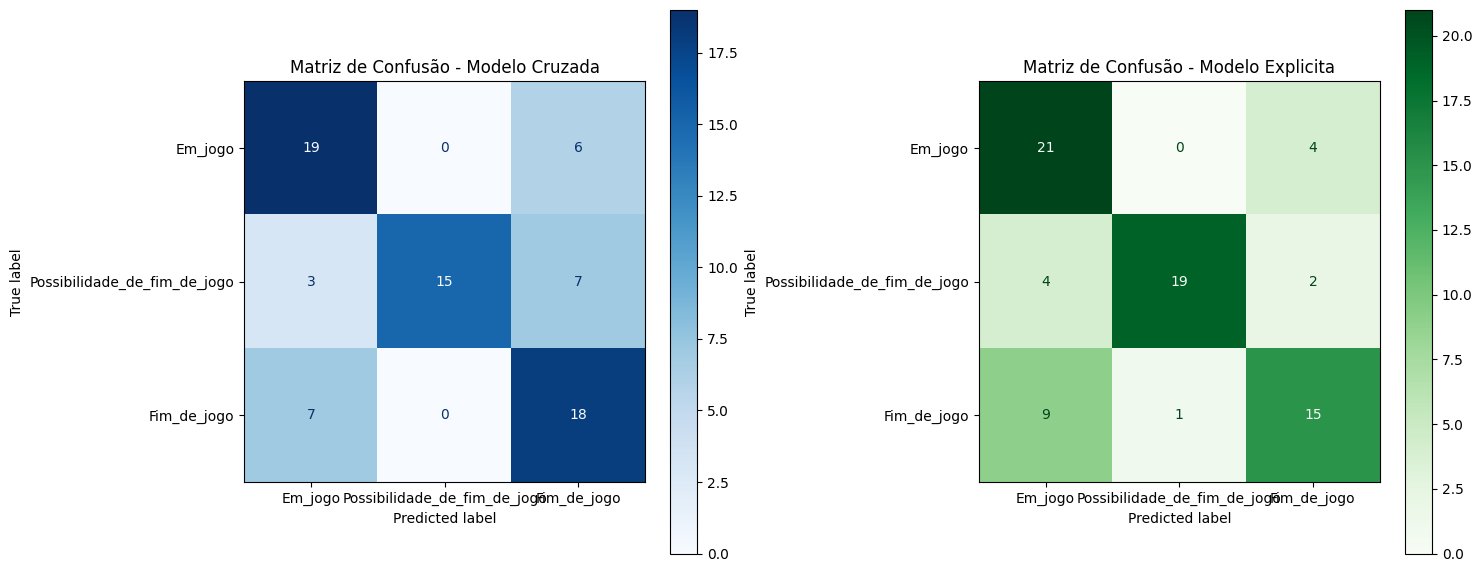

Relatório de Classificação - Modelo Cruzado:
Acurácia  0.6933333333333334
                              precision    recall  f1-score   support

                     Em_jogo       0.57      0.84      0.68        25
Possibilidade_de_fim_de_jogo       1.00      0.68      0.81        25
                 Fim_de_jogo       0.67      0.56      0.61        25

                    accuracy                           0.69        75
                   macro avg       0.74      0.69      0.70        75
                weighted avg       0.74      0.69      0.70        75

Relatório de Classificação - Modelo Explicito:
Acurácia  0.7333333333333333
                              precision    recall  f1-score   support

                     Em_jogo       0.62      0.84      0.71        25
Possibilidade_de_fim_de_jogo       0.95      0.76      0.84        25
                 Fim_de_jogo       0.71      0.60      0.65        25

                    accuracy                           0.73        75
     

In [182]:
clf = KNeighborsClassifier(n_neighbors=melhor_k)
clf.fit(tr_X, tr_y)
y_pred_expl = clf.predict(teste_X)  # usa DataFrame com nomes de features

# Matriz de confusão do modelo otimizado
cm_expl = confusion_matrix(teste_y, y_pred_expl)

grid.best_estimator_.fit(tr_X,tr_y)
y_pred_cru = grid.best_estimator_.predict(teste_X)

cm_cru = confusion_matrix(teste_y, y_pred_cru)

# Comparação das matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz original
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusão - Modelo Cruzada')

# Matriz otimizada
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_expl, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Matriz de Confusão - Modelo Explicita')

plt.tight_layout()
plt.show()

# Relatório de classificação do modelo otimizado
print("Relatório de Classificação - Modelo Cruzado:")
print('Acurácia ',accuracy_score(teste_y, y_pred_cru))
print(classification_report(teste_y, y_pred_cru, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))
# Relatório de classificação do modelo otimizado

print("Relatório de Classificação - Modelo Explicito:")
print('Acurácia ',accuracy_score(teste_y, y_pred_expl))
print(classification_report(teste_y, y_pred_expl, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))


In [183]:
print(f'Acurácia {accuracy_score(teste_y, y_pred)}')
print(classification_report(teste_y, y_pred))

Acurácia 0.7333333333333333
                              precision    recall  f1-score   support

                     Em_jogo       0.62      0.84      0.71        25
                 Fim_de_jogo       0.95      0.76      0.84        25
Possibilidade_de_fim_de_jogo       0.71      0.60      0.65        25

                    accuracy                           0.73        75
                   macro avg       0.76      0.73      0.74        75
                weighted avg       0.76      0.73      0.74        75

